In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Ubuntu'
#plt.rcParams['font.monospace'] = 'Ubuntu Mono'
#plt.rcParams['font.size'] = 12
#plt.rcParams['axes.labelsize'] = 11
#plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams['axes.titlesize'] = 12
#plt.rcParams['xtick.labelsize'] = 9
#plt.rcParams['ytick.labelsize'] = 9
#plt.rcParams['legend.fontsize'] = 11
#plt.rcParams['figure.titlesize'] = 13

In [2]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[2].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.amplitude_to_db(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [3]:
parent_dir = 'stocktest4'
sub_dirs= ['fold1']
features,labels = extract_features(parent_dir,sub_dirs)
labels = one_hot_encode(labels)

In [4]:
labels.shape

(24, 2)

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x,W,strides=[1,2,2,1], padding='SAME')

def apply_convolution(x,kernel_size,num_channels,depth):
    weights = weight_variable([kernel_size, kernel_size, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(conv2d(x, weights),biases))

def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1], 
                          strides=[1, stride_size, stride_size, 1], padding='SAME')

In [6]:
rnd_indices = np.random.rand(len(labels)) < 0.70

train_x = features[rnd_indices]
train_y = labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = labels[~rnd_indices]

In [7]:
frames = 41
bands = 60

feature_size = 2460 #60x41
num_labels = 2
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 200
num_hidden = 200

learning_rate = 0.01
training_iterations = 30

In [8]:
X = tf.placeholder(tf.float32, shape=[None,bands,frames,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

cov = apply_convolution(X,kernel_size,num_channels,depth)

shape = cov.get_shape().as_list()
cov_flat = tf.reshape(cov, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * depth, num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.sigmoid(tf.add(tf.matmul(cov_flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
cross_entropy = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

('Test accuracy: ', 0.625)


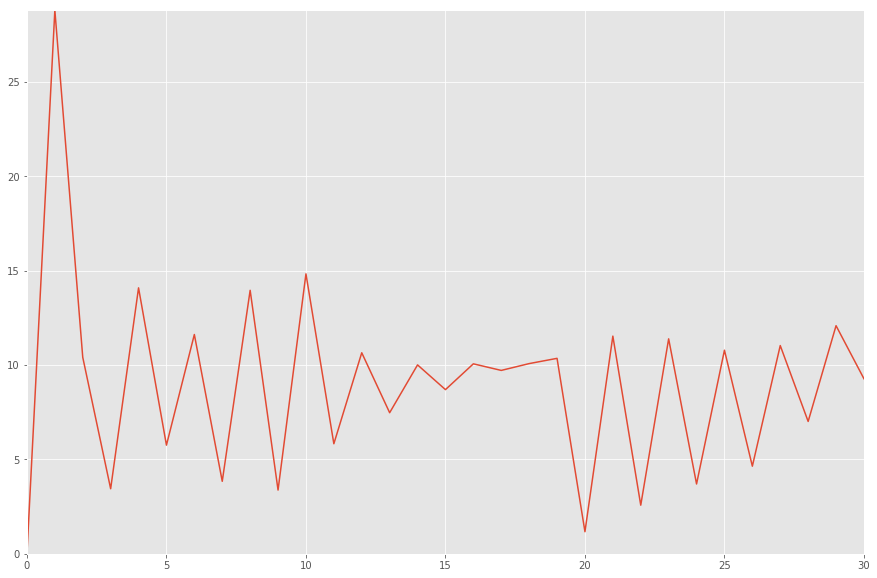

In [10]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as session:
    tf.global_variables_initializer().run()

    for itr in range(training_iterations):    
        offset = (itr * batch_size) % (train_y.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        _, c = session.run([optimizer, cross_entropy],feed_dict={X: batch_x, Y : batch_y})
        cost_history = np.append(cost_history,c)
    
    print('Test accuracy: ',round(session.run(accuracy, feed_dict={X: test_x, Y: test_y}) , 3))
    fig = plt.figure(figsize=(15,10))
    plt.plot(cost_history)
    plt.axis([0,training_iterations,0,np.max(cost_history)])
    plt.show()

In [ ]:
labels